[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)

#### based on Fig. 3 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol import AerosolMarine, AerosolBoreal
from atmos_cloud_sim_uj_utils import show_plot
from PySDM.initialisation import spectral_sampling as spec_sampling
from PySDM.physics import si
import numpy as np
import os
from matplotlib import pyplot
import matplotlib
from joblib import Parallel, delayed
import numba

In [6]:
numba.config.NUMBA_NUM_THREADS=2
rtol_x = 1e-3
rtol_thd = 1e-3
nt = 32
n_sd_per_mode = 16

In [7]:
CI = 'CI' in os.environ

updraft_list = np.geomspace(0.1, 10, 2 if CI else 5)
forg_list = np.linspace(0.1, 0.9, 2 if CI else 5)
subplot_list = ["a","b","c","d"]
models = ('bulk', 'film')

Acc = {"a": 30, "b": 134, "c": 160, "d": 540}

In [8]:
def compute(key, settings):
    settings.output_interval = settings.t_max
    settings.rtol_x = rtol_x
    settings.rtol_thd = rtol_thd
    simulation = Simulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.aerosol_modes_per_cc[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(subplot_list) * len(forg_list) * len(updraft_list)}')
output = dict(Parallel(verbose=10, n_jobs=-2)(
    delayed(compute)(subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)+model, Settings(
        dt=int(210 * si.m / w) / nt, n_sd_per_mode=n_sd_per_mode, 
        model=model,
        aerosol={
            "a": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["a"]), 
            "b": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["b"]), 
            "c": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["c"]), 
            "d": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["d"])
        }[subplot],
        w=w * si.m / si.s,
        spectral_sampling=spec_sampling.ConstantMultiplicity
    ))
    for w in updraft_list
    for Forg in forg_list
    for subplot in subplot_list
    for model in models
))

tasks scheduled: 200


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-2)]: Done 167 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  3

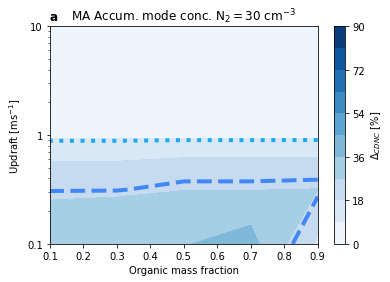

HTML(value="<a href='./tmpik53vm4d.pdf' target='_blank'>./tmpik53vm4d.pdf</a><br>")

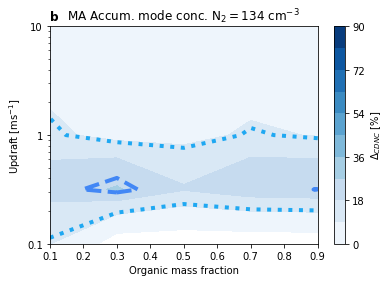

HTML(value="<a href='./tmpbenng26j.pdf' target='_blank'>./tmpbenng26j.pdf</a><br>")

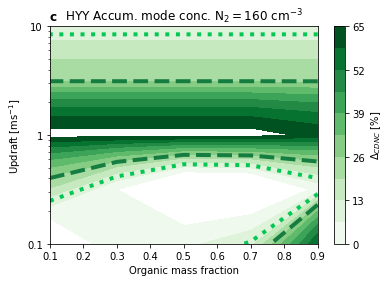

HTML(value="<a href='./tmp4y4n_itx.pdf' target='_blank'>./tmp4y4n_itx.pdf</a><br>")

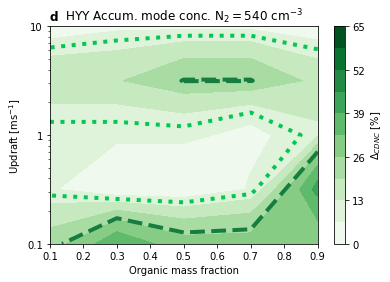

HTML(value="<a href='./tmp1vp8xtv5.pdf' target='_blank'>./tmp1vp8xtv5.pdf</a><br>")

In [5]:
for subplot in subplot_list:
    dCDNC = np.zeros((len(updraft_list), len(forg_list)))
    for i,w in enumerate(updraft_list):
        for j,Forg in enumerate(forg_list):
            key = subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)
            var = 'n_c_cm3'
            CDNC_film = np.array(output[key+"film"][var])[-1]
            CDNC_bulk = np.array(output[key+"bulk"][var])[-1]
            dCDNC[i,j] = (CDNC_film - CDNC_bulk) / CDNC_bulk * 100.0
            #print(w, Forg, CDNC_bulk, CDNC_film, dCDNC[i,j])

    if subplot == "a" or subplot == "b":
        colors = ["#1fa8f2","#4287f5"]
        cmap = "Blues"
        levels = np.linspace(0,90,11)
        title = f"MA Accum. mode conc. N$_2 = {Acc[subplot]}$ cm$^{{-3}}$"
    if subplot == "c" or subplot == "d":
        colors = ["#04c753","#157d3f"]
        cmap = "Greens"
        levels = np.linspace(0,65,11)
        title = f"HYY Accum. mode conc. N$_2 = {Acc[subplot]}$ cm$^{{-3}}$"

    pyplot.contour(forg_list, updraft_list, dCDNC, levels=[10,25], colors=colors, 
                   linestyles=[":", "--"], linewidths=4)
    pyplot.contourf(forg_list, updraft_list, dCDNC, cmap=cmap, levels=levels)
    pyplot.title(title)
    pyplot.title(subplot, weight="bold", loc="left")
    pyplot.xlabel("Organic mass fraction")
    pyplot.yscale("log")
    pyplot.yticks([0.1,1,10], ["0.1","1","10"])
    pyplot.ylabel("Updraft [ms$^{-1}$]")
    pyplot.colorbar(label="$\Delta_{CDNC}$ [%]")
    show_plot()